In [1]:
import cv2
import os

os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"

import time
import numpy as np
import tensorflow as tf
import time
import collections
import PIL
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from tqdm import tqdm_notebook as tqdm
import tensorflow.contrib.tensorrt as trt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
input_names = ['input_image', 'input_image_meta']

output_names = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois", "rpn_class", "rpn_bbox"]
output_names = ["output_" + name for name in output_names]

In [3]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [21]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11743133685593058386, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2485159377907739702
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7912942036303465219
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6514549760
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17212413964630344413
 physical_device_desc: "device: 0, name: Xavier, pci bus id: 0000:00:00.0, compute capability: 7.2"]

In [5]:
DEVICE = "/device:GPU:0"

# Create session and load graph
tf_config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf_sess = tf.Session(config=tf_config)

In [6]:
# with tf.device(DEVICE):
trt_graph = get_frozen_graph('../logs/mask_rcnn_512_cocoperson_0396_trt.pb')
tf.import_graph_def(trt_graph, name='')

In [7]:
# uncomment to visualize graph in tensorboard
writer = tf.summary.FileWriter('../logs')
writer.add_graph(tf_sess.graph)

In [8]:
image = cv2.imread('/home/jetson/Pictures/img_000000.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

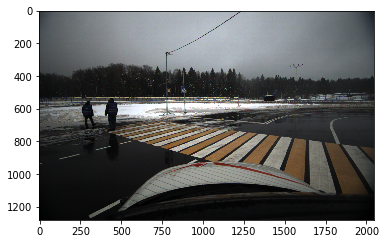

In [9]:
plt.imshow(image)

In [10]:
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtraces
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    if config.BACKBONE in ["mobilenetv1","mobilenetv2"]:
        return images.astype(np.float32)/127.5 - 1.0
    if config.BACKBONE in ["resnet50","resnet101"]:
        images.astype(np.float32) - config.MEAN_PIXEL

def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    # Currently supports ResNet and Mobilenet
    assert config.BACKBONE in ["resnet50", "resnet101", "mobilenetv1", "mobilenetv2"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    #logging.debug("h,w,scale: {},{},{}".format(h,w,scale))

    # Resize image using bilinear interpolation
    if scale != 1:
        image = cv2.resize(image, (round(h * scale), round(w * scale)), interpolation=cv2.INTER_LINEAR)
#         image = skimage.transform.resize(
#             image, (round(h * scale), round(w * scale)),
#             order=1, mode="constant", preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    boxes = boxes.astype(np.float32)
    h, w = shape
    #print("norm_boxes (h,w): ",h,w) #DEBUGGING
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    #print("boxes: ", boxes) #DEBUGGING
    #print("boxes-shift: ", boxes - shift) #DEBUGGING
    #print("normed boxes: ", np.divide((boxes - shift), scale).astype(np.float32)) #DEBUGGING
    return np.divide((boxes - shift), scale).astype(np.float32)

def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

In [11]:
class Config:
    def __init__(self):
        self.BACKBONE = "mobilenetv1"
        self.MEAN_PIXEL = [123.7, 116.8, 103.9]
        self.BACKBONE_STRIDES = [4, 8, 16, 32, 64]
        self.RPN_ANCHOR_SCALES = (16.0, 32.0, 64.0, 128.0, 256.0)
        self.RPN_ANCHOR_RATIOS = [0.5, 1, 2]
        self.RPN_ANCHOR_STRIDE = 1
        self.BATCH_SIZE = 1
        
config = Config()

In [12]:
import math

In [13]:
image = cv2.resize(image, (640, 384))

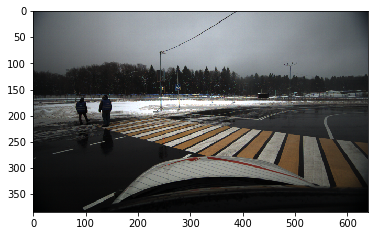

In [14]:
plt.imshow(image)

In [15]:
image_resized, window, scale, padding, crop = resize_image(image, 384, mode="pad64")
image_meta = compose_image_meta(image_id=1, original_image_shape=image.shape, 
                                image_shape=image_resized.shape, window=window, 
                                scale=scale, active_class_ids=list(range(81)))
image_resized = np.expand_dims(image_resized,0)
image_meta = np.expand_dims(image_meta,0)
image_molded = mold_image(image_resized, config)
image_shape = image_molded[0].shape

backbone_shapes = compute_backbone_shapes(config, image_shape)
a = generate_pyramid_anchors(
        config.RPN_ANCHOR_SCALES,
        config.RPN_ANCHOR_RATIOS,
        backbone_shapes,
        config.BACKBONE_STRIDES,
        config.RPN_ANCHOR_STRIDE)
anchors = norm_boxes(a, image_shape[:2])
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

In [16]:
image_shape

(384, 640, 3)

In [17]:
input_image = tf_sess.graph.get_tensor_by_name("input_image:0")
input_image_meta = tf_sess.graph.get_tensor_by_name("input_image_meta:0")
input_anchors = tf_sess.graph.get_tensor_by_name("input_anchors:0")
mrcnn_mask = tf_sess.graph.get_tensor_by_name("output_mrcnn_mask:0")
feed = {input_image:image_resized, input_image_meta:image_meta, input_anchors: anchors}

In [18]:
result = tf_sess.run(mrcnn_mask, feed_dict=feed)

In [20]:
%%timeit
result = tf_sess.run(mrcnn_mask, feed_dict=feed)

147 ms ± 8.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
